In [1]:
import xarray as xr
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
from itertools import cycle
from cmip_postprocess import *  
import warnings
warnings.filterwarnings('ignore')

2024-05-17 12:57:24.723298


In [2]:
# Configuration
paths = {
    'cmip': '../data/processed/',
    'MMF': '../data/raw/E3SM-MMF_1950-2015_Regrid180x360.nc',
    'E3SM': '../data/raw/E3SM_1950-2015_regrid180x360.nc',
    'ersst': '../data/raw/ersst.v5.195001-201512.180x360.nc',
    'Hadley_SST2': '../data/raw/HadISST.0-360.nc'
}
regions = { # AMO, NTA and CTI regions
    'amo': ([280, 360], [0, 65]),
    'nta': ([280, 360], [5, 25]),
    'cti': ([180, 270], [-6, 6]),
}
rolling_times = {
    'decadal': 121,
}

In [5]:
def get_input_names(path, model_file='source_id.txt'):
    with open(f"{path}{model_file}", "r") as f:
        models = [line.strip() for line in f]
    return models, [f"{path}{model}" for model in models]

models, model_files = get_input_names(paths['cmip'])
models.extend(['E3SM-MMF', 'E3SMv2', 'HadISST', 'ERSST'])
model_files.extend([paths['MMF'], paths['E3SM'], paths['Hadley_SST2'], paths['ersst']])

def process_models(models, files, regions, rolling_time=None):
    result_dict = {}
    for fn, model in zip(files, models):
        result_dict[model] = {}
        for region_name, region_coords in regions.items():
            result_dict[model][region_name],  _ = read_data_compute_anomalies(fn, {region_name: region_coords},
                                                                           data_type=get_data_type(model),
                                                                           rolling_time=rolling_time,
                                                                           model=model)
            decadal = rolling_times['decadal']
            time_slice = slice(int(decadal/2), -int(decadal/2))
            result_dict[model][region_name] = result_dict[model][region_name][region_name].isel(time=time_slice)

    return result_dict


def get_data_type(model):
    if model in ['ERSST']:
        return 3
    elif model in ['HadISST']:
        return 1
    else:
        return 2

### calculate the indexes based on the ssta

In [8]:
# Original data processing
orig_data = process_models(models, model_files, regions)

# Low-pass filter processing
lpf_data = process_models(models, model_files, regions, rolling_time=rolling_times['decadal'])

# High-pass filter processing by subtracting low-pass from original
hpf_data = {}
for model in models:
    hpf_data[model] = {}
    for region in regions:
        hpf_data[model][region] = orig_data[model][region] - lpf_data[model][region]

In [11]:
# Separate dictionaries for each region
# Initialize nested dictionaries for each data type
amo_data = {'orig_data': {}, 'hpf_data': {}, 'lpf_data': {}}
nta_data = {'orig_data': {}, 'hpf_data': {}, 'lpf_data': {}}
cti_data = {'orig_data': {}, 'hpf_data': {}, 'lpf_data': {}}

# containing model data where 'nta', and 'cti' can be keys
for dict_name, dict_ds in [('orig_data', orig_data), ('lpf_data', lpf_data), ('hpf_data', hpf_data)]:
    for model in dict_ds:
        amo_data[dict_name][model] = dict_ds[model].get('amo', None)
        nta_data[dict_name][model] = dict_ds[model].get('nta', None)
        cti_data[dict_name][model] = dict_ds[model].get('cti', None)


In [12]:

save_datasets_to_pickle(amo_data, '../data/processed/amo_ssta.pkl')
save_datasets_to_pickle(nta_data, '../data/processed/nta_ssta.pkl')
save_datasets_to_pickle(cti_data, '../data/processed/cti_ssta.pkl')


## Correlation heatmap

- reload the saved data

In [40]:
amo_data = load_from_pickle('../data/processed/amo_ssta.pkl')
nta_data = load_from_pickle('../data/processed/nta_ssta.pkl')
cti_data = load_from_pickle('../data/processed/cti_ssta.pkl')

In [44]:
def calculate_and_plot_correlations(ssta_cti_ds_dict, ssta_nta_ds_dict, ssta_amo_ds_dict, figure_path, hpf_ds=True):
    cor_cti_nta, cor_cti_amo = {}, {}
    models = [model.split('.')[0] for model in list(ssta_cti_ds_dict.keys())]
    
    for model, cti_ds, nta_ds, amo_ds in zip(models, ssta_cti_ds_dict.values(),
                                             ssta_nta_ds_dict.values(), 
                                             ssta_amo_ds_dict.values()):
        

            
        cor_cti_nta[model] = stats.linregress(cti_ds, nta_ds)[2]
        cor_cti_amo[model] = stats.linregress(cti_ds, amo_ds)[2]
       
    # Compute ensemble mean excluding specific models (adjust the slice as needed)
    exclude_last_n = 4  # Adjust based on how many models to exclude
    cor_cti_amo['CMIP-Ensemble'] = np.mean(list(cor_cti_amo.values())[:-exclude_last_n])
    cor_cti_nta['CMIP-Ensemble'] = np.mean(list(cor_cti_nta.values())[:-exclude_last_n])

    # Create a DataFrame from the dictionaries
    data = {
        'Model': list(cor_cti_nta.keys()),
        'CTI vs NTA': list(cor_cti_nta.values()),
        'CTI vs AMO': list(cor_cti_amo.values())
    }
    df = pd.DataFrame(data)
    df = df.set_index('Model')

    # Plotting the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Coefficient Heatmap')
    plt.savefig(figure_path, dpi=300)
    plt.show()
    


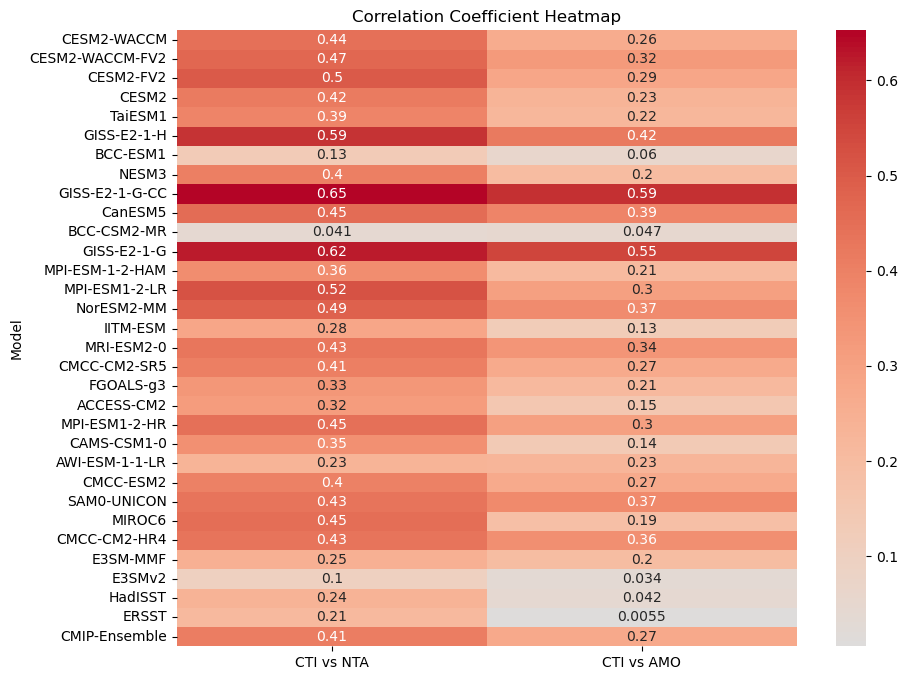

In [45]:
calculate_and_plot_correlations(cti_data['orig_data'], nta_data['orig_data'], amo_data['orig_data'], figure_path='Original Correlation Heatmap Map', hpf_ds=False)

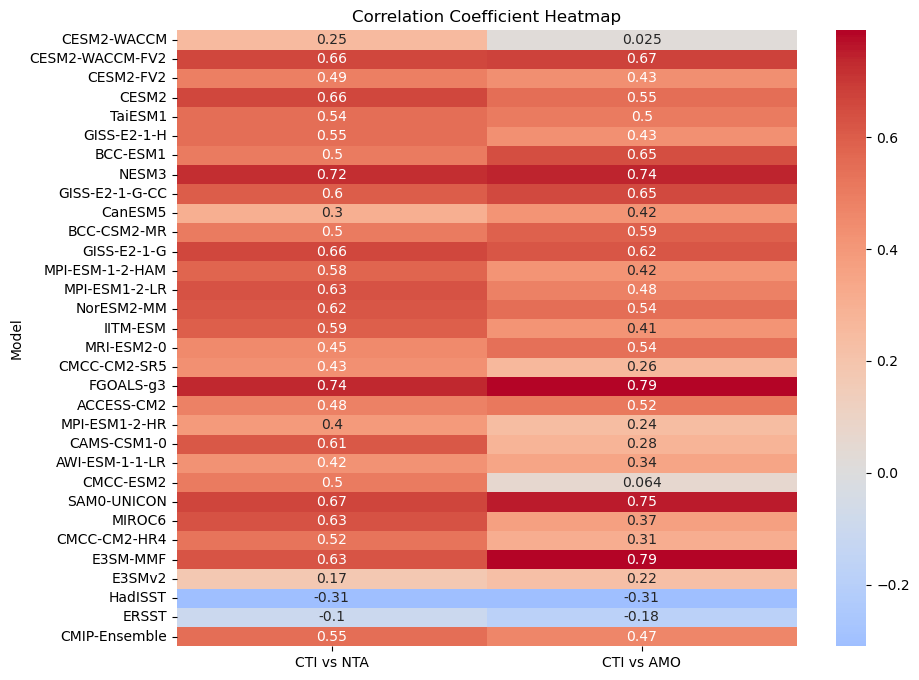

In [46]:
calculate_and_plot_correlations(cti_data['lpf_data'], nta_data['lpf_data'], amo_data['lpf_data'], figure_path='Low Pass Filtered (10 years running mean) Correlation Heatmap Map', hpf_ds=False)

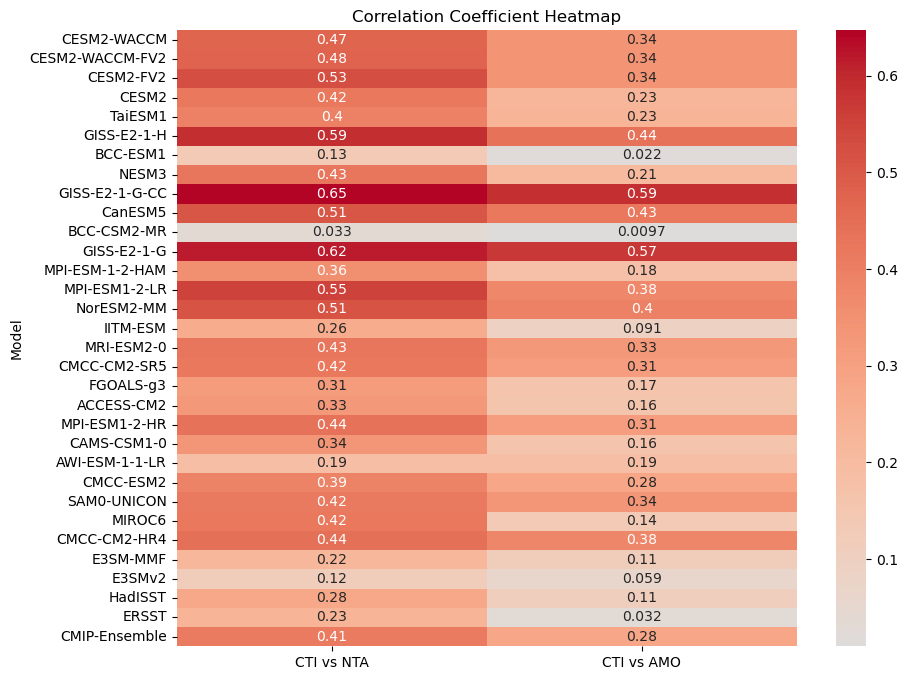

In [47]:
calculate_and_plot_correlations(cti_data['hpf_data'], nta_data['hpf_data'], amo_data['hpf_data'], figure_path='Correlation Heatmap Map', hpf_ds=True)